In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = True # Specify if noisy or not
Noise_level = 0.1 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

In [3]:
# objective = functions.sincos(Noise, Noise_level)
objective = functions.sin(Noise, Noise_level)

bounds = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(bounds) 

f = objective.func
print(f( np.array([2, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-1. 15.]]
[[1.08570266]
 [0.88148671]]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100
# set seed
seed = 0
# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES']
acquation_function = 'random'

In [5]:
def draw(n_random_draws=3):
    """ samples some points"""
    # np.random.seed(seed) 
    # should draw randomly
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_random_draws, dim))
    return X, f(X)

gp = GP_grad(bounds, Noise, Noise_level)

def get_kernel(sample_size=200):
    np.random.seed(seed)
    X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(sample_size, dim)))
    gp.set_data(X, f(X))
    # gp.optimize()
    gp.fit()
    return gp.get_hyper()

In [6]:
get_kernel()
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1, dim)
mu, covar = gp.posterior(Xtest)
s = np.sqrt(np.diag(covar))
mu = np.squeeze(mu)


Kt = gp.cov_RBF(Xtest, Xtest, gp.get_hyper())
K_11 = gp.K11(Xtest)
K_01 = gp.K01(Xtest)

In [7]:
gp.X.shape

(200, 1)

In [8]:
# gp.add_data(Xtest, f(Xtest))

In [9]:
# a = np.array([[1, 2], [3, 4], [5, 6]])
# b = np.array([[10, 20], [0.5, 0.1]])
# a, b
# test
# def sq_dist(x1, x2): # x1: N*d, x2: M*d  --> N*d
#     if x1.shape[1] != x2.shape[1]: # 2d
#         x1 = np.reshape(x1, (-1, x2.shape[1]))
#     return np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2*np.dot(x1, x2.T)

# def K01(Xtest, hyper=None):
#     variance = 1
#     lengthscale = 1

#     Xtest_p = Xtest[:, 0]
#     X_p = np.reshape(a[:, 0], (-1, 1))

#     sqdist = sq_dist(a, Xtest)
#     diff = X_p - Xtest_p
#     K_01 = (variance/(lengthscale**2)) * diff * np.exp(-0.5 * sqdist / (lengthscale**2))
#     return sqdist

In [10]:
# M, V = gp.joint_MVN(Xtest)
# M.shape, V.shape
# V
# gp.cov_RBF(gp.X, gp.X, gp.get_hyper())

In [11]:
# gp.posterior_grad(Xtest)

In [14]:
XQtest = np.linspace(-5, 5, 20).reshape(-1, dim)
XPtest = np.linspace(-5, 5, n).reshape(-1, dim)
Xt = np.vstack([XPtest, XQtest])
gp.posterior_joint_grad(0, 0, XPtest, XQtest)



ValueError: call K11 instead

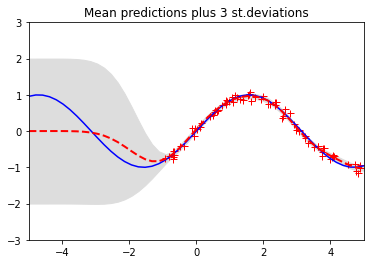

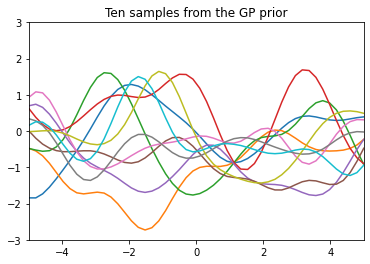

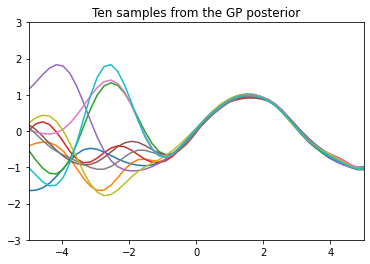

In [12]:
# plot
X = np.squeeze(gp.X)
y = np.squeeze(gp.y)

Xtest = np.squeeze(Xtest)

pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=7)
pl.plot(Xtest, np.sin(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")

pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [13]:
mu_grad, covar_grad = gp.posterior_grad(Xtest)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

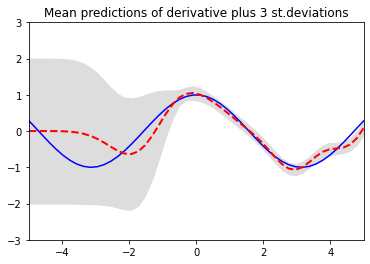

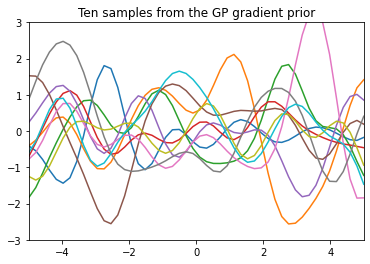

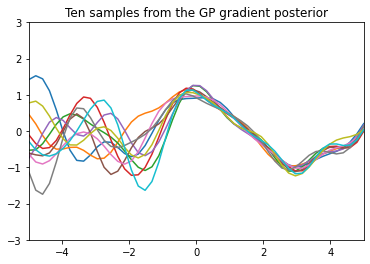

In [14]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
pl.plot(Xtest, np.cos(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

pl.plot(Xtest, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP gradient prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP gradient posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

## Gradient descent

In [19]:
gp = GP_grad(bounds, Noise, Noise_level)
mesh = np.linspace(-5, 15, 2000).reshape((-1, dim))
np.random.seed(seed)  

X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(4, dim)))
gp.set_data(X, f(X))
gp.fit()
mu, covar = gp.posterior(mesh)


n_iter = 20
lr_init = 10
alpha = 0.5

history = []
history_lr = []
w = X[0].reshape(-1, 1)
    
def grad(gp, x): # input a fit gp, find the gradient at x
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))

#     # partial x2
#     gp.set_p(1)
#     m2, v2 = gp.posterior_grad(x)
#     s2 = np.sqrt(np.diag(v2))
#     m2 = np.squeeze(m2)
#     return np.vstack([m1, m2])
    return m1.reshape(-1, 1)


grad(gp, w)

array([[0.36559337]])

$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

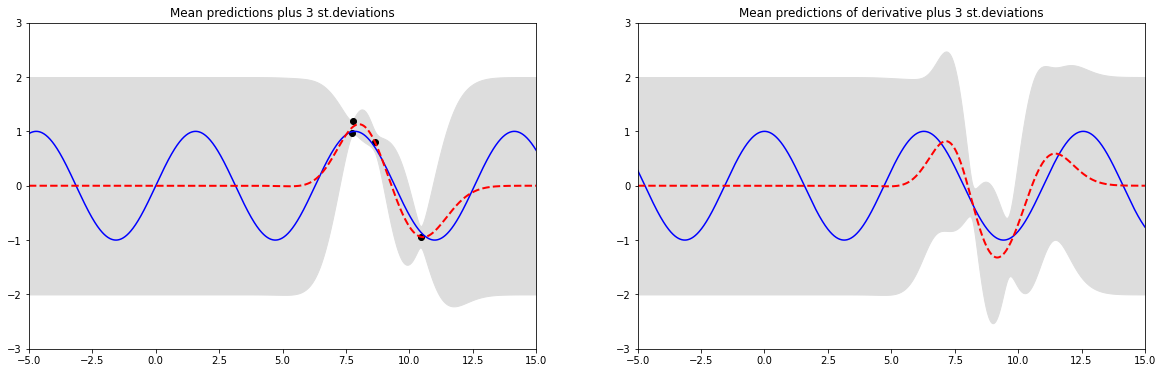

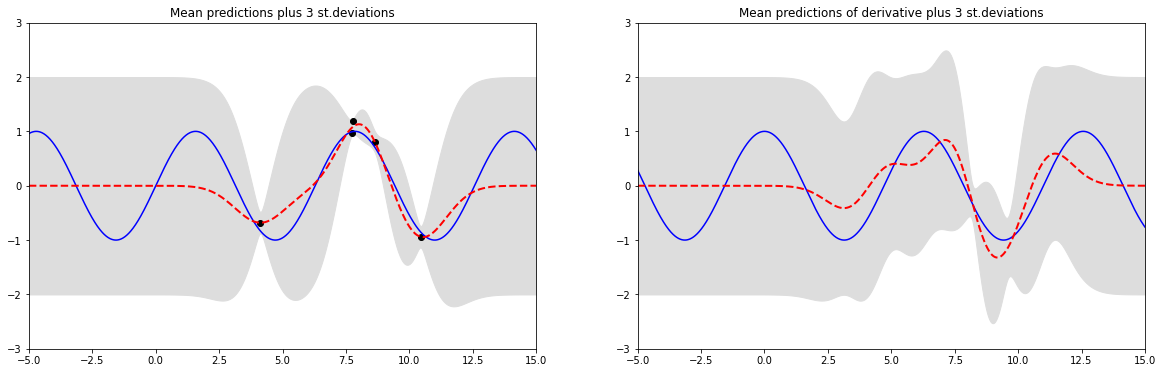

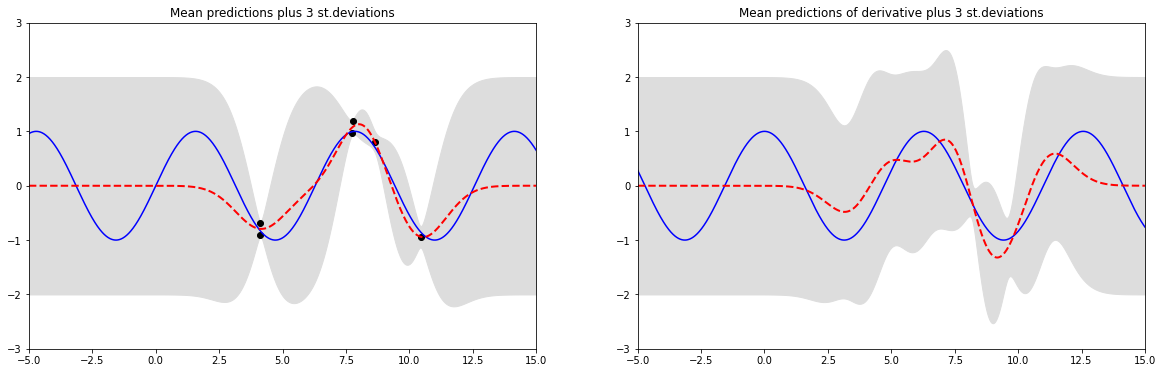

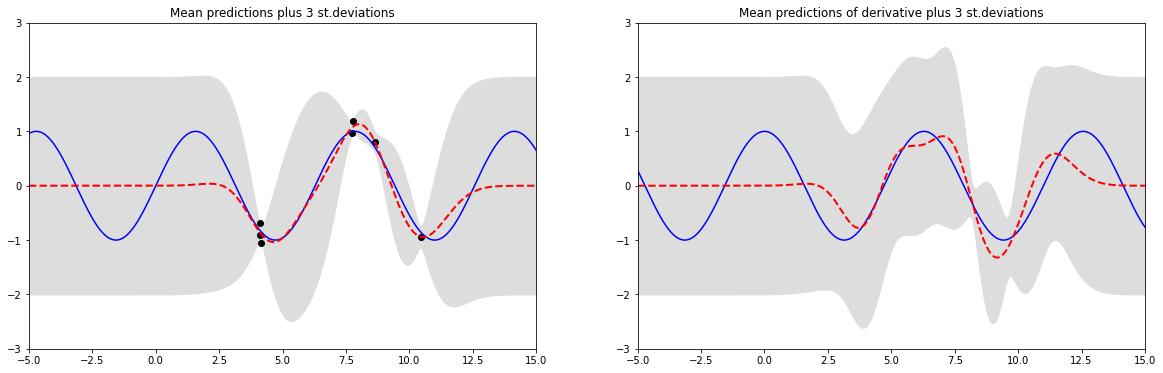

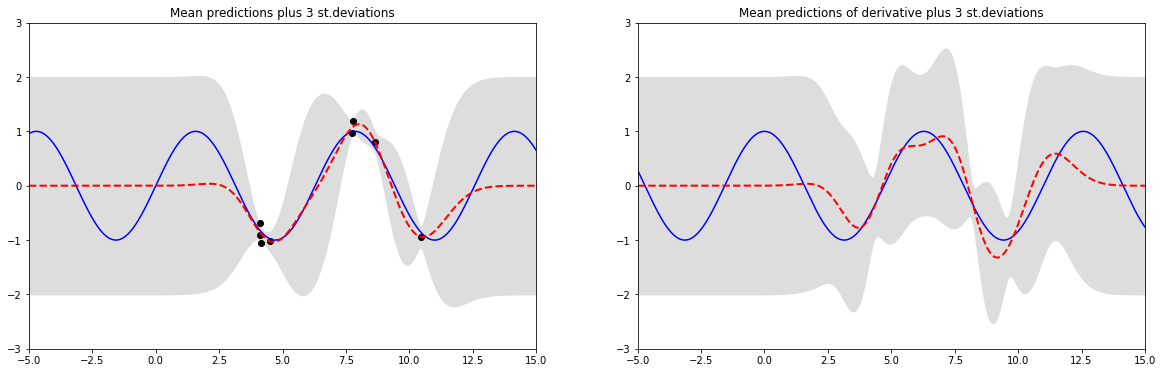

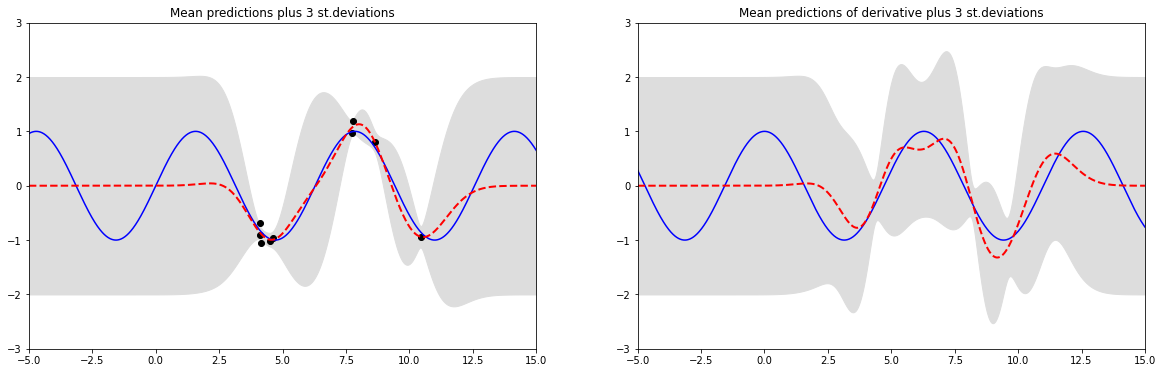

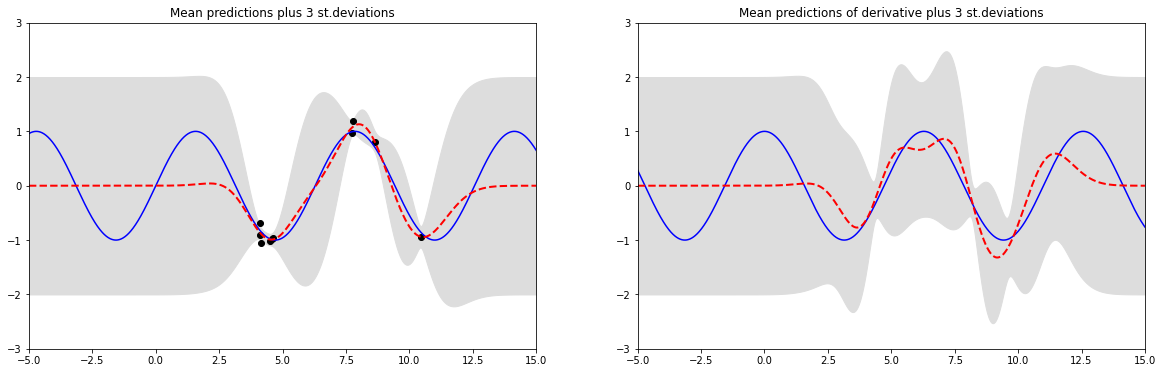

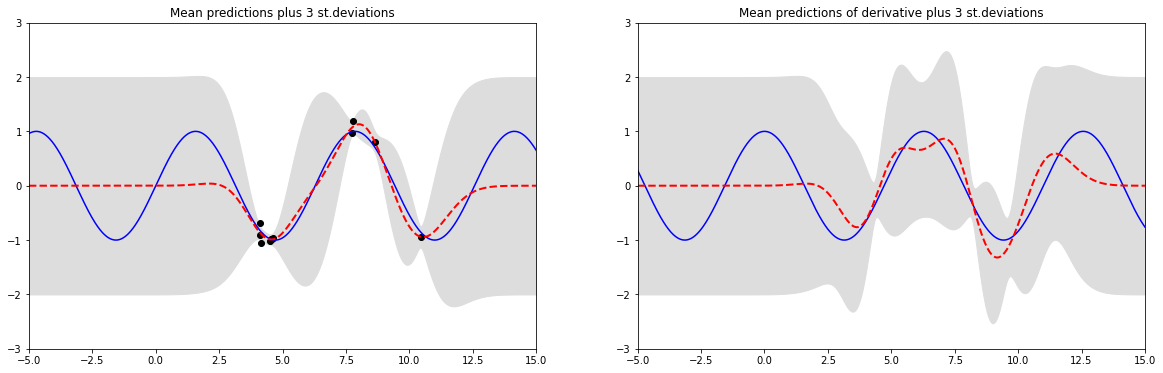

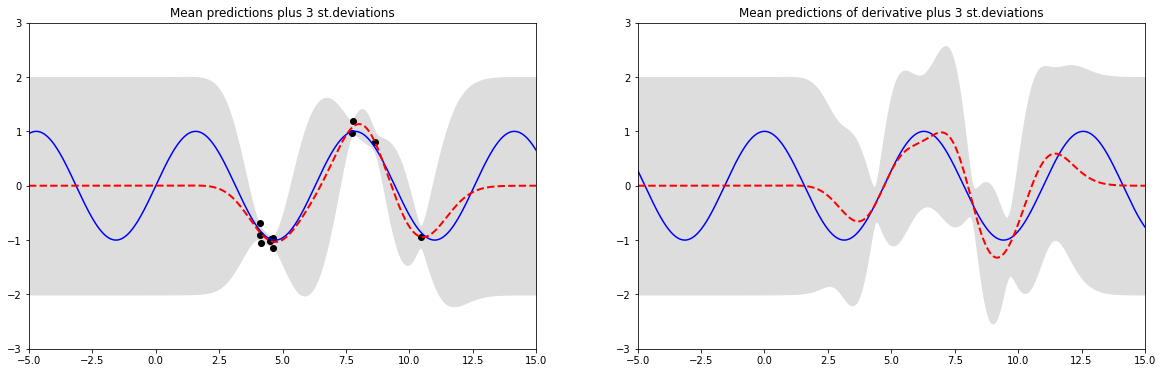

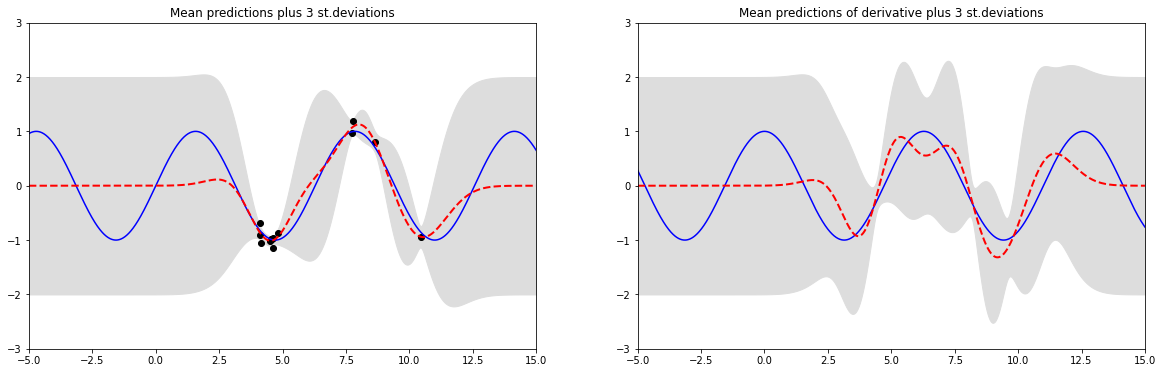

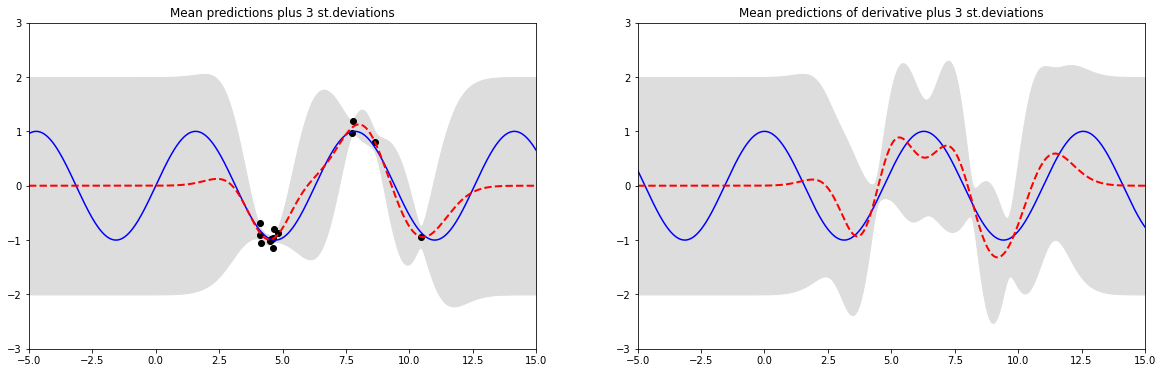

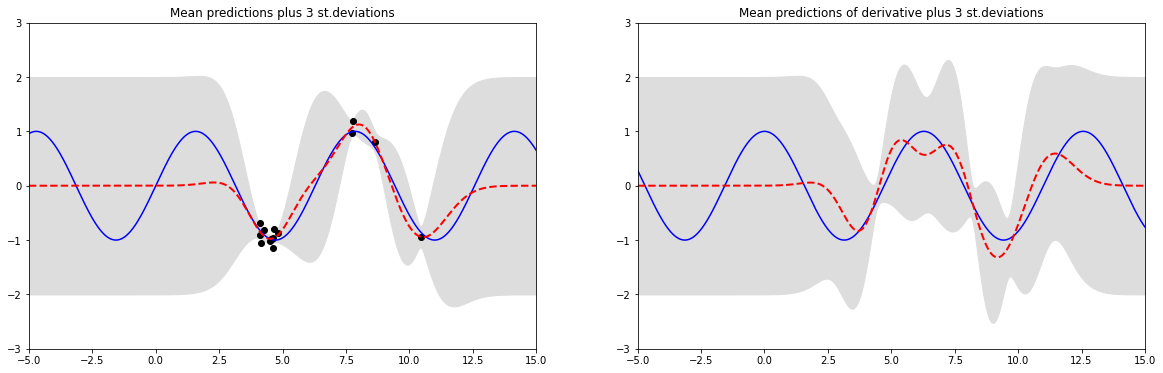

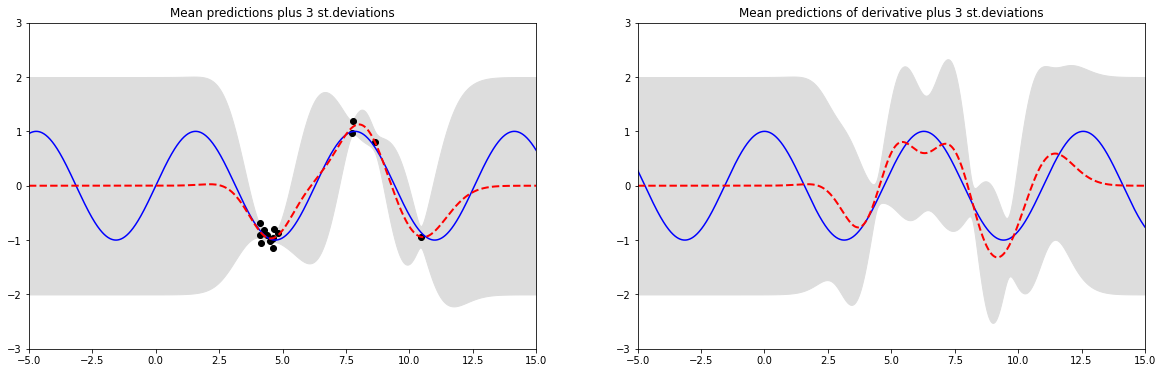

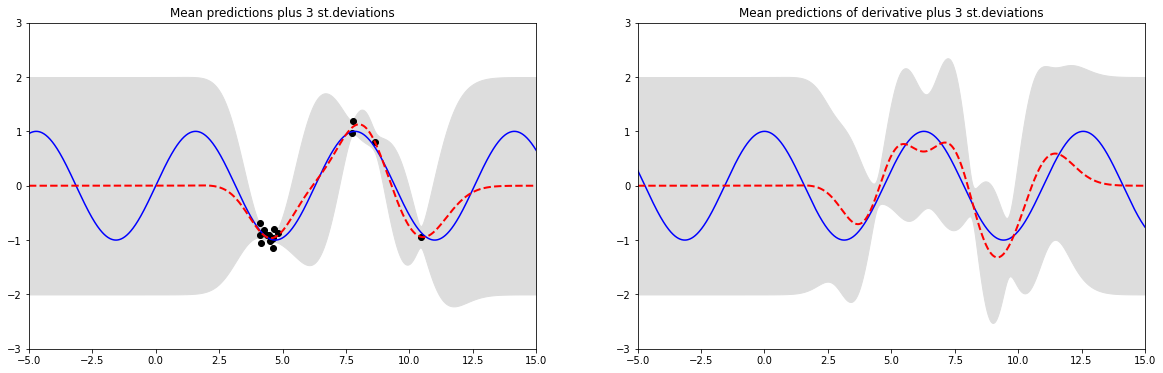

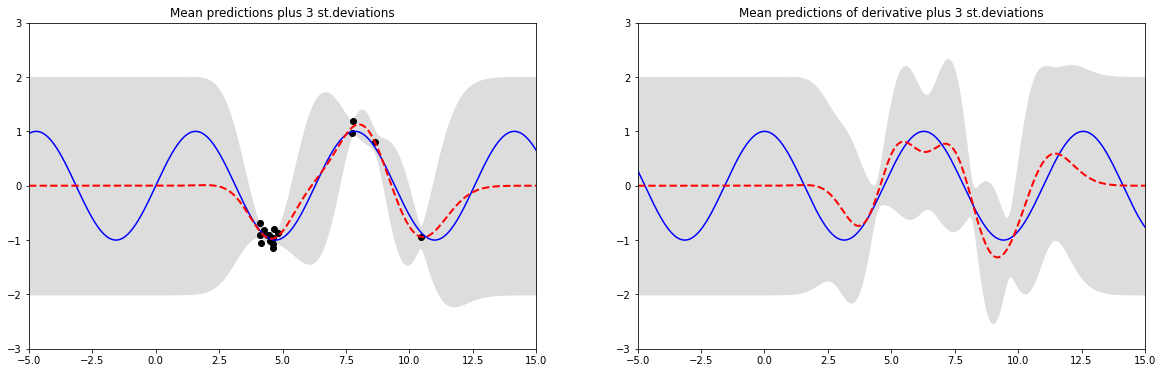

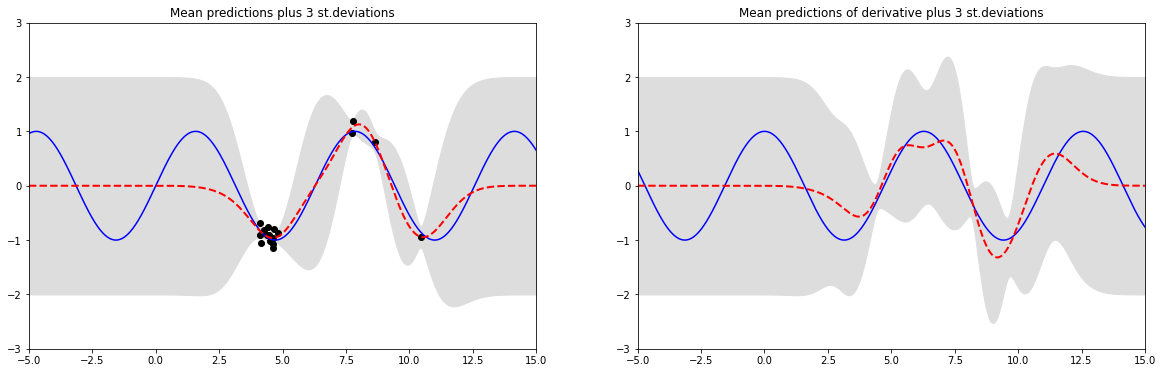

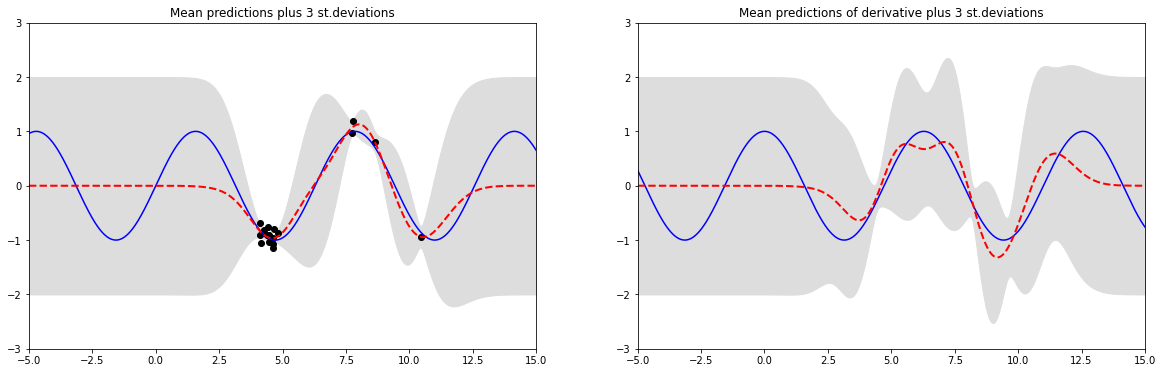

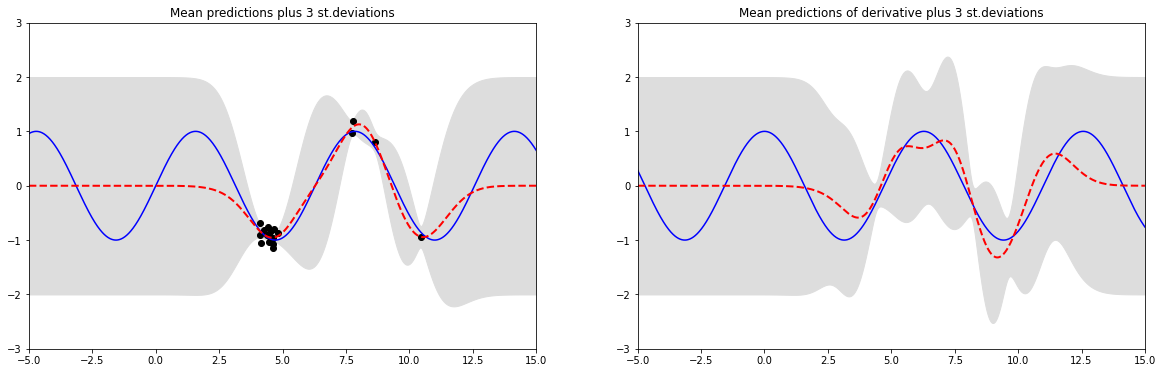

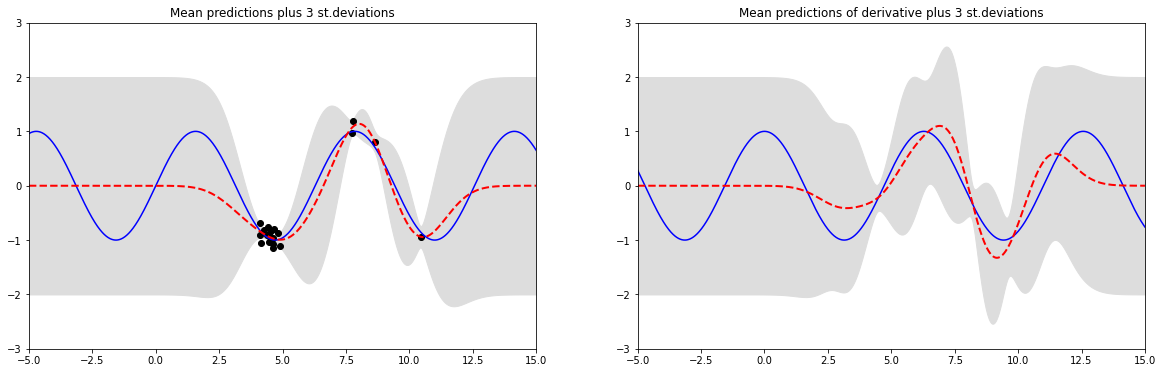

In [20]:
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(mesh)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(mesh)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)


    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(mesh, mesh, gp.get_hyper())
    K_11 = gp.K11(mesh)
    K_01 = gp.K01(mesh)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(mesh.flat, np.sin(mesh.flat), 'b-')
    ax1.fill_between(mesh.flat, mu-2*s, mu+2*s, color="#dddddd")

    ax1.plot(mesh, mu, 'r--', lw=2)
    fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')
    ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
    ax2.plot(mesh.flat, np.cos(mesh.flat), 'b-')
    ax2.fill_between(mesh.flat, mu_grad-2*s_grad, mu_grad+2*s_grad, color="#dddddd")

    ax2.plot(mesh.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
    ax2.axis([-5, 15, -3, 3])

    filename = 'sin_' + str(i) + '_noise' +'.png'
    pl.savefig('Result_Plots/' + filename)
    pl.show()  

    
    # gradient ascent
    gradient = grad(gp, w)
    desc = -gradient
    
    # automatically choose the learning rate
    lr = lr_init
    while f(w + lr*gradient) > f(w) + alpha*lr*np.dot(desc, gradient):
        # while condition not satisfied, divide the learning rate by two
        lr = 0.5 * lr
    
    w = w + lr * desc
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    gp.fit()
    

In [21]:
# Creates the .gif from the saved plots for the 2D_Plots dir.
filenames = []
for i in range(1, 20):
    filename = 'sin_' + str(i) + '_noise' + '.png'
    filenames.append(filename)

frames=[]
for filename in filenames:
    frames.append(imageio.imread('Result_Plots/' + filename))
exportname = 'sin_noise.gif'

kargs = { 'duration': 0.5 }
imageio.mimsave(exportname, frames, 'GIF', **kargs)